<h2> Predict Loan Defaulters - Ensembles</h2>
This notebook will take as input a pre-processed dataset from the previous notebook <Link> <br>

<h3>Notebook Setup</h3>

<ol>
  <li>Create Transformers to handle diffrents processing needs of our dataset </li>
  <li>Apply Transformation to our Dataset</li>
  <li>Perform Prediction of Loan Defaulters</li>
  <li>Model Interpretation</li>
</ol> 

### Steps in the process
1. [Baseline_Model](#baseline_model)
2. [LightGBM_Model](#lgb_classifier)
3. [MLP Model](#mlp_classifier)
4. [Feature Importance](#feature_importance)

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np
import pickle

#sklearn libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.classifier import StackingCVClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import average_precision_score

#helper functions
import helper_functions as helpers
import modeling_helper_functions as mhf
import parameter_tuning_helper as pt
import yagmail

# classification algorithms
from mlxtend.classifier import EnsembleVoteClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from datetime import datetime
import itertools
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

import os
import warnings

# Viz Libraries
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.featu

In [2]:
from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"
# scientific notation
pd.options.display.float_format = '{:.2f}'.format

# helper functions used throughout this project
print_header = lambda msg: print(f"{msg}\n{'-'*len(msg)}")

In [3]:
notebook_start_time = datetime.now()

In [4]:
CPU_COUNT = -1
CROSS_VAL_COUNT = 10
SCORING_METRIC = 'f1_weighted'
ESTIMATOR_COUNT = 100
MAX_EVALUATION = 90
EARLY_STOPPING = 50
RANDOM_SEED = 2019

In [5]:
# training data
train_set = pd.read_csv('lc_train_cleaned_woe.csv')

# test data_2018
test_set = pd.read_csv('lc_test_cleaned_woe.csv')

print(" Dataset: Train_Shape {}, Test_Shape {}".format(train_set.shape,test_set.shape))

 Dataset: Train_Shape (487353, 10), Test_Shape (146206, 10)


### **Create Feature Matrix and Labels**

In [6]:
# drop our target feature
X_train = train_set.drop('loan_status', axis=1)
# save our target feature in a y variable
y_train = train_set.loan_status

# drop our target feature
X_test= test_set.drop('loan_status', axis=1)
# save our target feature in a y variable
y_test = test_set.loan_status

# review splits
print("X_train: {}, y_train: {}".format(X_train.shape,y_train.shape))

# review splits
print("X_test: {}, y_test: {}".format(X_test.shape,y_test.shape))

X_train: (487353, 9), y_train: (487353,)
X_test: (146206, 9), y_test: (146206,)


In [7]:
X_train.dtypes

open_act_il            float64
open_rv_24m            float64
int_rate               float64
il_util                float64
term                     int64
initial_list_status    float64
open_rv_12m            float64
revol_util             float64
inq_fi                 float64
dtype: object

In [8]:
scale_values =train_set.loan_status.value_counts().tolist()
imbalance_weight = round((scale_values[1:].pop()) / (scale_values[:1].pop()), 2)
imbalance_weight

0.65

In [9]:
X_test['term']  =X_test['term'].astype('int')
X_train['term']  =X_train['term'].astype('int')

In [10]:
# %load_ext autoreload

### **Store Category Feature Indexes**

In [11]:
# Extract categorical features from the dataframe
cat_features= np.where(train_set.drop("loan_status", axis=1).apply(pd.Series.nunique) < 10)[0].tolist()
cat_names = train_set.drop("loan_status", axis=1).columns[cat_features].tolist()
X_train[cat_names] = X_train[cat_names].astype(np.int)
X_test[cat_names] = X_test[cat_names].astype(np.int)

In [12]:
categorical_features_indices = cat_features
categorical_features_indices

[4, 5]

In [13]:
X_train.dtypes

open_act_il            float64
open_rv_24m            float64
int_rate               float64
il_util                float64
term                     int64
initial_list_status      int64
open_rv_12m            float64
revol_util             float64
inq_fi                 float64
dtype: object

### **Voting Classifiers**

In [14]:
# LightGBM
light_gbm_tuned = lgb.LGBMClassifier(boosting_type='gbdt', categorical_list=1,
               class_weight='balanced', colsample_bytree=0.5507964546135609,
               device_type='CPU', feature_fraction=0.9532815816399243,
               importance_type='split', learning_rate=0.044, max_depth=4,
               min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.022492071755475896, n_estimators=100, n_jobs=-1,
               num_leaves=63, objective='binary', random_state=None,
               reg_alpha=0.5500326075151979, reg_lambda=0.8122427947625087,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

#  Logistic Regression
lr_model = LogisticRegression(class_weight='balanced',n_jobs=CPU_COUNT,solver='lbfgs',)

# knn tuned
knn_tuned = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                     weights='uniform')

# Multi-Layer Perceptron
mlp_classifier = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

### Pipelines

In [15]:
# Logistic Regression
lr_pipe = Pipeline([['standard scaler', StandardScaler()],['Logistic Regression',lr_model]])

# Light GBM
lightGBM_pipe = Pipeline([['standard scaler', StandardScaler()],['LightGBM',light_gbm_tuned]])

# knn classifier
knn_pipe = Pipeline([['standard scaler', StandardScaler()],['KNNClassifier', knn_tuned]])

# MLP Classifier
mlp_pipe = Pipeline([['standard scaler', StandardScaler()],['MLP Classifier', mlp_classifier]])

### Build Voting Classifier

In [16]:
# Tree Voting Classifier
voting_classifier = EnsembleVoteClassifier(clfs=[lightGBM_pipe,mlp_pipe,knn_pipe,lr_pipe],
                                           weights=[0.3,0.3,0.2,0.2],
                                           voting='soft')

# pipe of tree-based classifiers
voting_pipe =[lightGBM_pipe, mlp_pipe,knn_pipe,lr_pipe, voting_classifier]

# corresponding labels
clf_labels =["lightGBM_pipe","mlp_pipe", "knn_pipe","LogisticR_pipe", "Voting_pipe"]

# iterate for each classifiers scores
for clf, label in zip(voting_pipe, clf_labels):
    print(label)
    mhf.train_model(clf,
                    X_train,y_train,
                    scoring_metric=SCORING_METRIC,
                    number_of_folds=CROSS_VAL_COUNT,
                    n_jobs=CPU_COUNT)
    print('   ')

lightGBM_pipe
Cross Validation f1_weighted Training Score for Pipeline is 80.002
Time elapsed (hh:mm:ss.ms) 0:00:05.735919
   
mlp_pipe
Cross Validation f1_weighted Training Score for Pipeline is 79.998
Time elapsed (hh:mm:ss.ms) 0:01:01.220994
   
knn_pipe
Cross Validation f1_weighted Training Score for Pipeline is 79.522
Time elapsed (hh:mm:ss.ms) 0:01:58.255281
   
LogisticR_pipe
Cross Validation f1_weighted Training Score for Pipeline is 72.711
Time elapsed (hh:mm:ss.ms) 0:00:01.684005
   
Voting_pipe
Cross Validation f1_weighted Training Score for EnsembleVoteClassifier is 80.005
Time elapsed (hh:mm:ss.ms) 0:02:26.624157
   


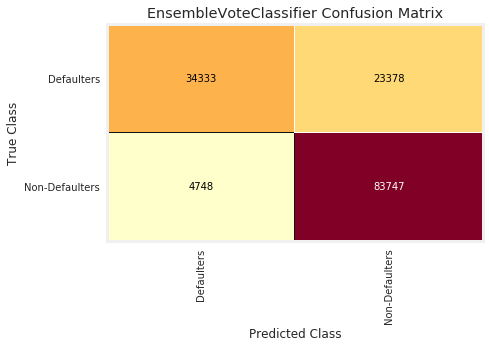

In [17]:
mhf.plot_confusion_matrix(X_train,y_train,
                          X_test, y_test,
                          model=voting_classifier,
                          encoder={0:'Defaulters', 1: 'Non-Defaulters'})

## Stacking Classifier

`Stacking Classifier:` Stacking, short for stacked generalization is a classifier that uses the outputs of base learners to make a prediction using a blender or meta learner that then makes a final prediction. <br>
In essence, this classifier is creating hierarchies where individual learners are organized into different layers with each layers output serving as the training data for the next layer

* Hard voting: Makes the final prediction by counting the most voted class (classification scenario)
* Soft voting: Soft voting takes into account the average probability of each class and assumes the winner is the class with the highest average probability.

We will use the following classifiers:
* Diverse Voting Classifier
* Linear Voting Classifier
* Tree Voting Classifier
* MLP Classifier
* `Meta_Classifier` = Logistic Regression

In [18]:

# Starting from v0.16.0, StackingCVRegressor supports
# `random_state` to get deterministic result.
stacking_classifier= StackingCVClassifier(classifiers=
                                          [lightGBM_pipe, mlp_pipe, knn_pipe, lr_pipe],
                                          use_probas=True,
                                          n_jobs=CPU_COUNT,
                                          cv=CROSS_VAL_COUNT,
                                          stratify=True,
                                          meta_classifier=lr_pipe,
                                          random_state=RANDOM_SEED
                                         )

In [19]:
# train lightgbm model
mhf.train_model(stacking_classifier,
                X_train,y_train,
                scoring_metric=SCORING_METRIC,
                number_of_folds=CROSS_VAL_COUNT,
                n_jobs=CPU_COUNT)

Cross Validation f1_weighted Training Score for StackingCVClassifier is 79.513
Time elapsed (hh:mm:ss.ms) 0:28:06.770778


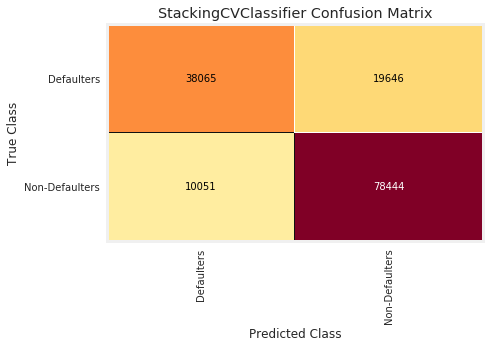

In [20]:
mhf.plot_confusion_matrix(X_train,y_train,
                          X_test, y_test,
                          model=stacking_classifier,
                          encoder={0:'Defaulters', 1: 'Non-Defaulters'})

### **Evaluate on hold-out Test Set**
<a id="holdouttest"></a>

In [21]:
test_set_2019 = pd.read_csv('lc_hold_out_test_woe.csv')

# split test set into features and target
X_test_2019 = test_set_2019.drop('loan_status', axis=1)
y_test_2019 = test_set_2019.loan_status

# review splits
print("X_test: {}, y_test: {}".format(X_test_2019.shape,y_test_2019.shape))

X_test: (146206, 9), y_test: (146206,)


In [22]:
# Extract categorical features from the dataframe
X_test_2019[cat_names] = X_test_2019[cat_names].astype(np.int)

In [23]:
stacking_classifier= stacking_classifier.fit(X_train,y_train)
voting_classifier = voting_classifier.fit(X_train,y_train)

optimal threshold:0.43


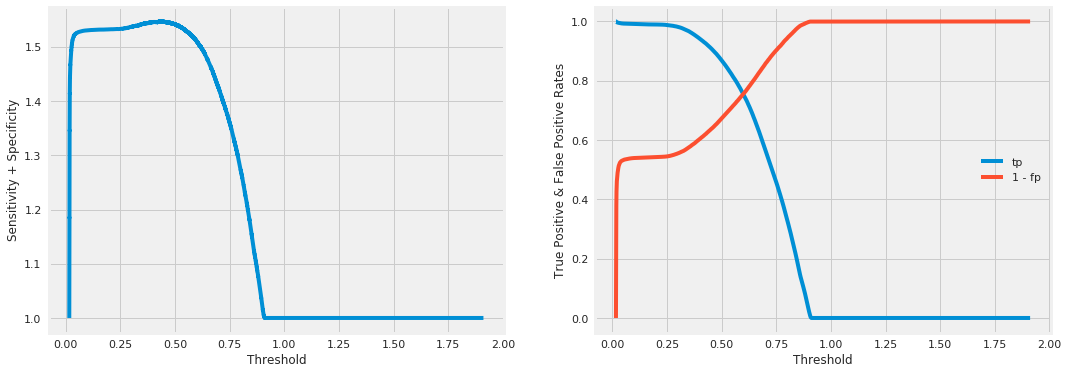

In [24]:
threshold = helpers.define_optimal_threshold(stacking_classifier,X_test_2019,y_test_2019)

In [25]:
threshold

0.43

In [26]:
# make a prediction using lightGBM classifier
stacking_classifier_ypred = stacking_classifier.predict_proba(X_test_2019)[:,1]
stacking_classifier_ypred = np.where(stacking_classifier_ypred > threshold, 1, 0)

# make a prediction using lightGBM classifier
voting_classifier_ypred = voting_classifier.predict_proba(X_test_2019)[:,1]
voting_classifier_ypred = np.where(voting_classifier_ypred > threshold, 1, 0)

In [27]:
average_precision = average_precision_score(y_test_2019, stacking_classifier_ypred)
average_precision = average_precision_score(y_test_2019, voting_classifier_ypred)

print('Voting Average precision-recall score: {0:0.2f}'.format(average_precision))
print('Stacking Average precision-recall score: {0:0.2f}'.format(average_precision))

Voting Average precision-recall score: 0.77
Stacking Average precision-recall score: 0.77


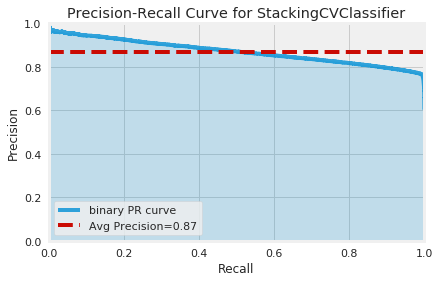

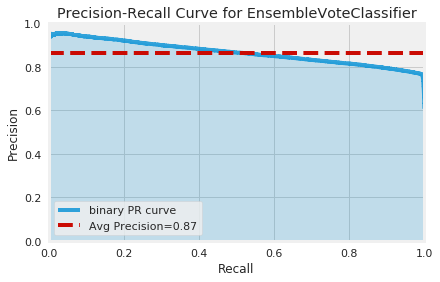

In [28]:
mhf.plot_precision_recall_curve_1(X_train,y_train, X_test_2019,y_test_2019, stacking_classifier)
mhf.plot_precision_recall_curve_1(X_train,y_train, X_test_2019,y_test_2019, voting_classifier)

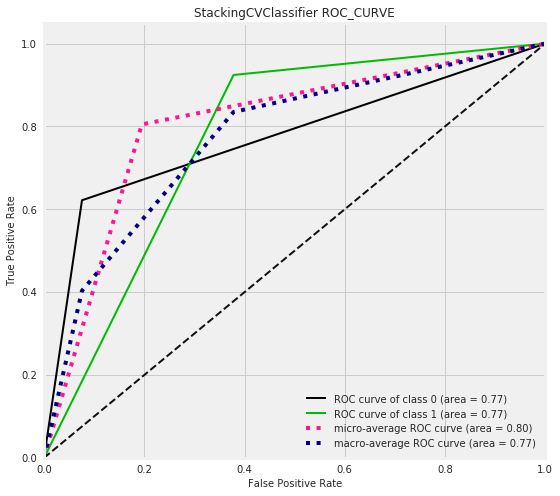

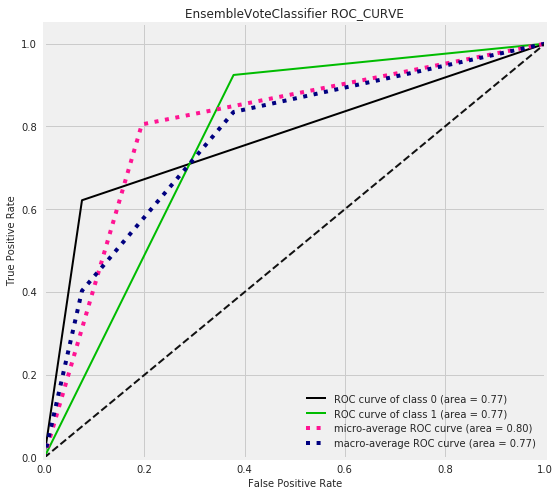

In [29]:
mhf.plot_roc_auc_curve(stacking_classifier_ypred,y_test_2019,model=stacking_classifier)
mhf.plot_roc_auc_curve(stacking_classifier_ypred,y_test_2019,model=voting_classifier)

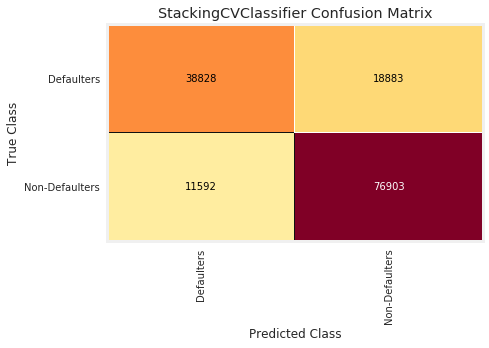

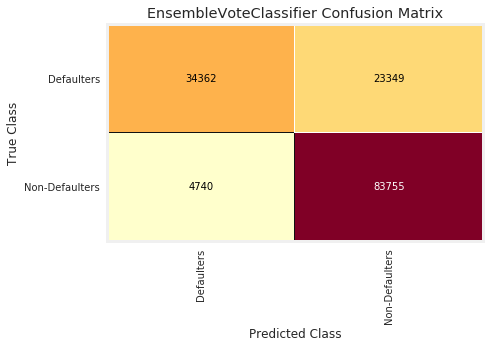

In [30]:
mhf.plot_confusion_matrix(X_train,y_train,
                          X_test_2019, y_test_2019,
                          model=stacking_classifier,
                          encoder={0:'Defaulters', 1: 'Non-Defaulters'})

mhf.plot_confusion_matrix(X_train,y_train,
                          X_test_2019, y_test_2019,
                          model=voting_classifier,
                          encoder={0:'Defaulters', 1: 'Non-Defaulters'})

In [31]:
import yagmail

In [32]:
print("End of Run!")

yag = yagmail.SMTP('lingard570116@gmail.com', 'Avanti#38!').send('marcelkore@gmail.com', 'Processing completed for ENSEMBLE NOTEBOOK')

End of Run!
